Thiết bị sử dụng: cuda

--- Sprint 1: Tải và Chuẩn bị dữ liệu (Từ file CSV/JSON) ---
Đã tải 'partner' làm nhãn (target). Số lớp: 2
Đã tải 3 features (dense) từ DE_target.csv.
Đã tải 3170 features (sparse) từ DE.json.

--- Thông tin Đồ thị ---
Tên dataset: DE (tải từ file)
Tổng số nút (người dùng): 9498
Tổng số cạnh (quan hệ): 153138
Số lượng đặc trưng mỗi nút (kết hợp): 3173
Số lượng lớp (class): 2
Đồ thị có nút bị cô lập? False
Đồ thị có self-loop? False

Số nút huấn luyện (train): 6648
Số nút validation (val): 950
Số nút kiểm thử (test): 1900

--- Sprint 2: Thiết kế và Huấn luyện GNN ---

--- Kiến trúc mô hình GraphSAGE ---
GraphSAGE(
  (conv1): SAGEConv(3173, 128, aggr=mean)
  (conv2): SAGEConv(128, 2, aggr=mean)
)

--- Bắt đầu huấn luyện ---
Epoch: 020, Loss: 0.1991, Train: 0.9522, Val: 0.9463, Test: 0.9547
Epoch: 040, Loss: 0.1313, Train: 0.9606, Val: 0.9600, Test: 0.9605
Epoch: 060, Loss: 0.1087, Train: 0.9677, Val: 0.9653, Test: 0.9674
Epoch: 080, Loss: 0.0972, Train: 0.9687, Va

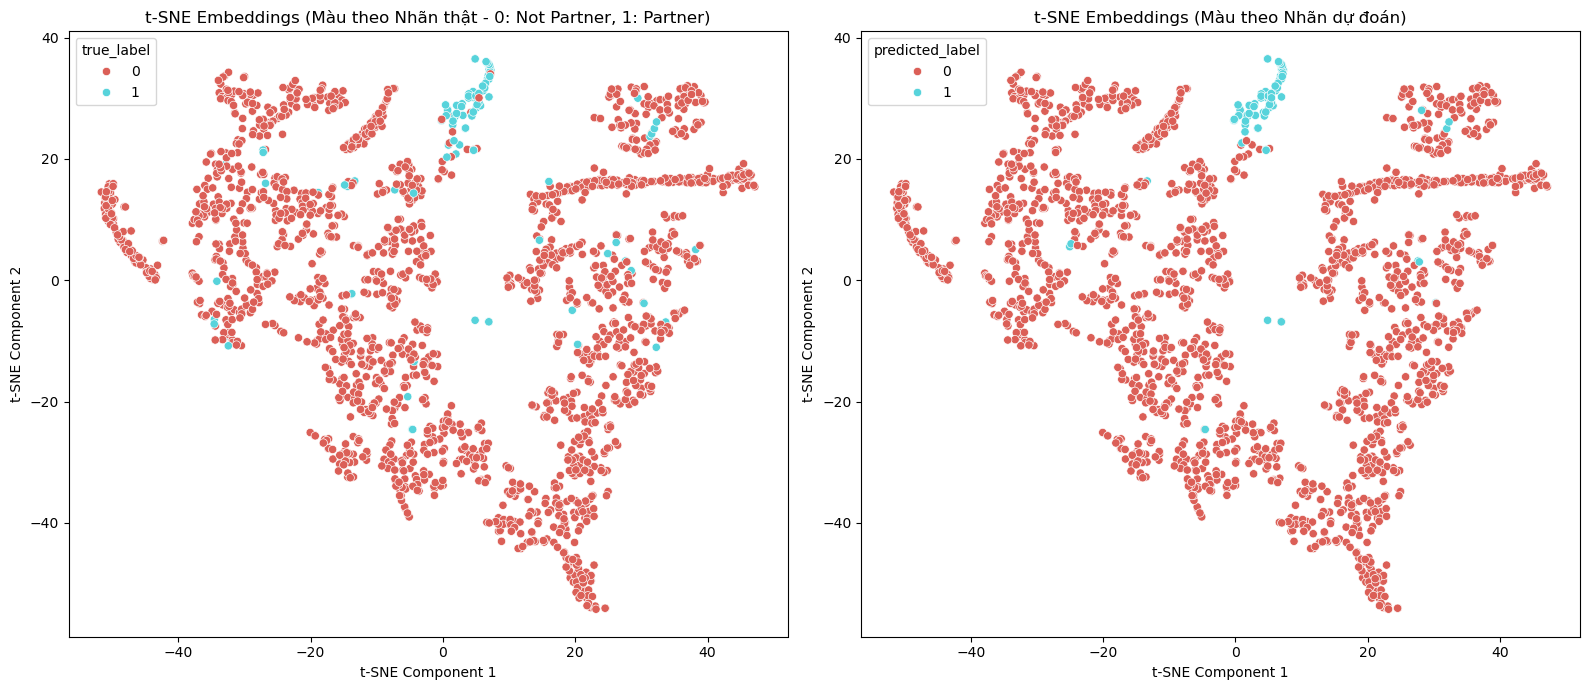

--- Hoàn thành ---


In [5]:
import torch
import torch.nn.functional as F
import os
import pandas as pd
import numpy as np
import json
from torch_geometric.data import Data # Import class Data
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # Dùng để chuẩn hóa

# Chọn thiết bị (GPU nếu có)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị sử dụng: {device}")

# ==================================================================
# == SPRINT 1: XÂY DỰNG ĐỒ THỊ (TẢI TỪ FILE CÓ SẴN)
# ==================================================================
print("\n--- Sprint 1: Tải và Chuẩn bị dữ liệu (Từ file CSV/JSON) ---")

# !!! Đường dẫn tới thư mục chứa file của bạn
root_path = r'D:\1-REFERENCES\11-URA\twitch\DE' 
edges_file = 'DE_edges.csv'
target_file = 'DE_target.csv'
features_file = 'DE.json'

# --- 1. Tải Target (Nhãn) và Features (Dense) ---
try:
    target_df = pd.read_csv(os.path.join(root_path, target_file))
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file {target_file} tại {root_path}")
    print("Vui lòng kiểm tra lại đường dẫn và tên file.")
    raise

# Sắp xếp theo new_id để đảm bảo thứ tự node 0, 1, 2...
target_df = target_df.sort_values(by='new_id').reset_index(drop=True)
num_nodes = len(target_df)

# *** SỬA 1: Dùng cột 'partner' làm nhãn (target) ***
if 'partner' not in target_df.columns:
    print(f"LỖI: Không tìm thấy cột 'partner' trong file {target_file}")
    raise
    
# Chuyển True/False thành 1/0
target_df['partner'] = target_df['partner'].astype(int) 
y = torch.tensor(target_df['partner'].values, dtype=torch.long)
num_classes = y.max().item() + 1 # Sẽ là 2 (lớp 0 và 1)
print(f"Đã tải 'partner' làm nhãn (target). Số lớp: {num_classes}")

# Tạo map từ string_id sang int_id (index)
id_to_int_map = pd.Series(target_df.index, index=target_df['id']).to_dict()

# --- 2. Tải Edges (Cạnh) ---
edge_df = pd.read_csv(os.path.join(root_path, edges_file))
# Chuyển đổi thành định dạng [2, num_edges]
edge_index = torch.tensor(edge_df.values.T, dtype=torch.long)

# --- 3. Tải và Kết hợp Features (Đặc trưng) ---

# *** SỬA 2: Tải features (dense) từ target_df ***
scaler = StandardScaler()
# Chuyển 'mature' (True/False) thành int (1/0)
target_df['mature'] = target_df['mature'].astype(int)
# Chuẩn hóa các cột số
dense_features_numeric = scaler.fit_transform(target_df[['days', 'views']])
# Lấy các cột bool/int
dense_features_bool = target_df[['mature']].values
# Nối các features dense lại
dense_features = np.hstack([dense_features_numeric, dense_features_bool]).astype(np.float32)
print(f"Đã tải {dense_features.shape[1]} features (dense) từ {target_file}.")

# *** SỬA 3: Tải features (sparse) từ JSON ***
with open(os.path.join(root_path, features_file), 'r') as f:
    features_json = json.load(f)

# Tìm số chiều features (sparse)
max_feat_id = 0
for str_id, feat_list in features_json.items():
    if feat_list:
        max_feat_id = max(max_feat_id, max(feat_list))
num_sparse_features = max_feat_id + 1

# Tạo ma trận features (sparse)
sparse_features = np.zeros((num_nodes, num_sparse_features), dtype=np.float32)

# Điền dữ liệu features (sparse)
for str_id, feat_list in features_json.items():
    if str_id in id_to_int_map:
        int_id = id_to_int_map[str_id] # Lấy int_id (0, 1, 2...)
        sparse_features[int_id, feat_list] = 1.0 # Đặt các vị trí feature = 1.0
print(f"Đã tải {num_sparse_features} features (sparse) từ {features_file}.")

# *** SỬA 4: Nối (Concatenate) cả hai loại features ***
x_np = np.hstack([dense_features, sparse_features])
x = torch.tensor(x_np, dtype=torch.float)
num_node_features = x.shape[1] # Đây là tổng số features mới

# 4. Tạo đối tượng Data của PyTorch Geometric
data = Data(x=x, edge_index=edge_index, y=y)

# 5. Phân chia Train/Val/Test
transform = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
data = transform(data)

# In thông tin đồ thị
print("\n--- Thông tin Đồ thị ---")
print(f"Tên dataset: DE (tải từ file)")
print(f"Tổng số nút (người dùng): {data.num_nodes}")
print(f"Tổng số cạnh (quan hệ): {data.num_edges}")
print(f"Số lượng đặc trưng mỗi nút (kết hợp): {num_node_features}") # Sẽ là (3 + 3705)
print(f"Số lượng lớp (class): {num_classes}") # Sẽ là 2
print(f"Đồ thị có nút bị cô lập? {data.has_isolated_nodes()}")
print(f"Đồ thị có self-loop? {data.has_self_loops()}")

print(f"\nSố nút huấn luyện (train): {data.train_mask.sum().item()}")
print(f"Số nút validation (val): {data.val_mask.sum().item()}")
print(f"Số nút kiểm thử (test): {data.test_mask.sum().item()}")

# Đưa dữ liệu lên device (GPU/CPU)
data = data.to(device)


# ==================================================================
# == SPRINT 2: THIẾT KẾ VÀ HUẤN LUYỆN GNN (GraphSAGE)
# ==================================================================
print("\n--- Sprint 2: Thiết kế và Huấn luyện GNN ---")

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
    def get_embedding(self, x, edge_index):
        x = self.conv1(x, edge_index)
        return x.detach()

# Khởi tạo mô hình
# (Tự động lấy num_node_features và num_classes mới)
model = GraphSAGE(
    in_channels=num_node_features,
    hidden_channels=128,
    out_channels=num_classes
).to(device)

print("\n--- Kiến trúc mô hình GraphSAGE ---")
print(model)

# 2. Huấn luyện với Cross-Entropy Loss và Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# (Các hàm train() và test() giữ nguyên y như cũ)
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
    test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    
    return train_acc, val_acc, test_acc

# 3. Theo dõi quá trình học
print("\n--- Bắt đầu huấn luyện ---")
best_val_acc = 0
for epoch in range(1, 201):
    loss = train()
    train_acc, val_acc, test_acc = test()
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_graphsage.pth')

    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
              f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

print("--- Huấn luyện hoàn tất ---")


# ==================================================================
# == SPRINT 3: ĐÁNH GIÁ VÀ TRỰC QUAN HÓA
# ==================================================================
print("\n--- Sprint 3: Đánh giá và Trực quan hóa ---")

# 1. Tải model tốt nhất và đánh giá
model.load_state_dict(torch.load('best_model_graphsage.pth'))
model.eval()

out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

# Tính Accuracy và F1-Score trên tập Test
test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
test_f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='macro')

print(f"\n--- Kết quả đánh giá trên tập Test ---")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-Score (Macro): {test_f1:.4f}")

# 2. Trực quan hóa Embedding
print("\nĐang thực hiện giảm chiều t-SNE để trực quan hóa (có thể mất vài phút)...")
embeddings = model.get_embedding(data.x, data.edge_index).cpu().numpy()
labels = data.y.cpu().numpy()
test_mask = data.test_mask.cpu().numpy()

test_embeddings = embeddings[test_mask]
test_labels = labels[test_mask]
test_preds = pred[test_mask].cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(test_embeddings)

# Tạo DataFrame để vẽ
df_tsne = pd.DataFrame({
    'tsne_1': embeddings_2d[:, 0],
    'tsne_2': embeddings_2d[:, 1],
    'true_label': test_labels,
    'predicted_label': test_preds
})

# Vẽ biểu đồ
plt.figure(figsize=(16, 7))

# Biểu đồ 1: Màu theo nhãn THẬT
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_tsne,
    x='tsne_1', y='tsne_2',
    hue='true_label',
    palette=sns.color_palette("hls", num_classes),
    legend="full"
)
plt.title('t-SNE Embeddings (Màu theo Nhãn thật - 0: Not Partner, 1: Partner)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Biểu đồ 2: Màu theo nhãn DỰ ĐOÁN
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_tsne,
    x='tsne_1', y='tsne_2',
    hue='predicted_label',
    palette=sns.color_palette("hls", num_classes),
    legend="full"
)
plt.title('t-SNE Embeddings (Màu theo Nhãn dự đoán)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

print("--- Hoàn thành ---")

In [ ]:
import sys
print("GNN (Tốt):", sys.executable)

GNN (Tốt): c:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310\python.exe


In [ ]:
import os
print("--- GNN (TỐT) ---")
print("Biến môi trường PATH:")
print(os.environ['PATH'])

--- GNN (TỐT) ---
Biến môi trường PATH:
c:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310;C:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310;C:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310\Library\mingw-w64\bin;C:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310\Library\usr\bin;C:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310\Library\bin;C:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310\Scripts;C:\Users\micha\AppData\Local\anaconda3\envs\motiondiffuse310\bin;C:\Users\micha\AppData\Local\anaconda3\condabin;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9\libnvvp;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Fi